# Introduction

## Background

**Objective:**  
Identify how leaders inspire graduates and what role gender plays in their approach.

**Approach:**  
Use Natural Language Processessing (NLP) to explore NPR's top 350 commencement speeches. Identify themes and patterns using exploratory data analysis, topic modeling, and sentiment analysis. 

**Data:** 
* Speeker name, school, and year scraped from NPR's top 350 commencement speeches
* Speech transcripts were scraped from YouTube using custom selenium script

**Results Summary:**  
Top topics: Politics, Career, Hope, Culture, Education
* Male distrobution: Hope, Politics, Career, Education, Culture
* Female distrobution: Hope, Education, Culture, Career, Politics

Sentiment is generally positive but reflects an upside down bell curve. Both males and females begin and end on strong positive notes and use the middle to speak to passion points. 


## Packages

In [ ]:
from pymongo import MongoClient
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import pickle
import re
import string
import logging


from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import make_blobs, fetch_mldata
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import scipy.sparse

from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

# Scraping and Storing Data

## Beautiful Soup Scraping Top Speeches Form NPR

In [17]:
def load_page_for_scraping():
    """Requests connection to the NPR page and prints confirmation if the page is
    loaded correctly. If fails to load, reports error. Returns beautiful soup
    object for scraping."""

    print("Connecting to NPR")
    url = 'http://apps.npr.org/commencement/'
    response = requests.get(url)
    status = response.status_code
    if status == 200:
        print("Page loaded succcessfully")
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        return soup
    else:
        print(f"Error code: {status}")
        return

def scrape_NPR():
    """For NPRs 350 top commencement speeches, scrapes the speeker name, school name,
    and year speech was given. Returns list of speech information."""
    soup = load_page_for_scraping()
    print("Scraping speeker name, school, and year.")

    speeches = []
    speech_names = soup.find_all('h2', class_='speech-name')
    speech_schools = soup.find_all('p', class_='speech-school')
    speech_years = soup.find_all('p', class_='speech-year')

    for i in range(len(speech_names)):
        speeches.append([speech_names[i].text, speech_schools[i].text, speech_years[i].text])

    print("Speeker names, school, and year scraped.")

    return speeches

In [ ]:
speeches = scrape_NPR()

In [ ]:
speeches[:5]

## Selenium Scraping Video Transcripts From YouTube

In [ ]:
def connecting_YouTube():
    """Connects to YouTube and confirms scraping permissions."""
    print("Confirming scraping allowance on YouTube.")
    url = 'https://www.youtube.com/robots.txt'
    response  = requests.get(url)
    print(response.text)
    return

connecting_YouTube()

In [ ]:
# track transcripts that have been scraped and transcripts that remain in case process stops
# part way through

all_scraped_content = []
remaining = [speech[0] for speech in speeches]
i = 1

In [ ]:
def gettranscript(speech, i):
    """loads a selenium driver with youtube search result for the speech provided.
    Scrapes the transcript from that youtube page and returns a list of the speech
    information with the transcript."""

    waittime = 10
    sleeptime = [5,15]

    # connect to selenium driver
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver

    driver = webdriver.Chrome(chromedriver)

    sleep(random.uniform(sleeptime[0],sleeptime[1]))
    
    # set wait conditions for optimal scraper performance
    wait = WebDriverWait(driver, 3)
    presence = EC.presence_of_element_located
    visible = EC.visibility_of_element_located

    query = speech[0] + ' ' + speech[1] + ' ' + speech[2] + ' ' + 'commencement speech'
    driver.get("https://www.youtube.com/results?search_query=" + str(query))

    wait.until(visible((By.ID, "video-title")))
    driver.find_element_by_id("video-title").click()
    sleep(random.uniform(2,4))
    
    # try and except sequence to continue process if a video / transcript does not exist
    try:
        element = driver.find_element_by_xpath('//button[@aria-label="More actions"]')
    except:
        msg = 'could not find options button'
        driver.quit()
        print(msg)
        return msg

    try:
        sleep(random.uniform(2,5))
        element.click()
    except:
        msg = 'could not click'
        driver.quit()
        print(msg)
        return msg

    try:
        element = driver.find_element_by_xpath('//ytd-menu-service-item-renderer[@aria-selected="false"]')
    except:
        msg = 'could not find transcript in options menu'
        driver.quit()
        print(msg)
        return msg

    try:
        sleep(random.uniform(2,5))
        element.click()
    except:
        msg = 'could not click'
        driver.quit()
        print(msg)
        return msg

    try:
        sleep(random.uniform(2,4))
        element = driver.find_element_by_xpath('//ytd-transcript-body-renderer[contains(@class, "style-scope")]')
    except:
        msg = 'could not find transcript text'
        driver.quit()
        print(msg)
        return msg

    tscript = element.text
    
    #append transcript to list along with the speaker name, school, and speech year
    body_text_ls = [speech[0], speech[1], speech[2], tscript]

    driver.quit()
    print(f'Speech number {i}, {speech[0]} scraped')

    return body_text_ls

In [ ]:
# iterate through list of speeches obtained from NPR scraping
# look up each speech on YouTube and scrape the transcript

for speech in speeches:
    scraped_content = gettranscript(speech, i)
    all_scraped_content.append(scraped_content)
    i += 1
    remaining.pop(0)
    
# Note: if process above breaks, re-run with only the speeches in the remaining list

In [ ]:
# Store all scraped content in pickle to prevent losing data if system errors
with open('scraped_content.pkl', 'wb') as f:
    pickle.dump(all_scraped_content, f)

## Uploading to MongoDB Database

In [ ]:
# For speeches that did not have transcripts on YouTube, they were manually added to a list pickled
# in a different document. Read in manual list.

manually_added_speeches = pickle.load( open( "manual_speeches.pkl", "rb" ) )

In [ ]:
def upload_to_mongo(scraped_list):
    """conneccts to mongo database 'speeches'. Uploads raw content from commencement
    speech web scraping into database."""
    
    client = MongoClient()

    # connect to database within mongoDB
    speech_db = client.speeches

    # add each speech to MongoDB
    for speech in scraped_content:
        speech_dict = {'name': speech[0],
                       'school': speech[1],
                       'year': speech[2],
                       'speech': speech[3]}
        speech_db.speech_collection.insert_one(speech_dict)

    print("All speeches uploaded to Mongo.")
    print("Speech count in Mongo:", speech_db.speech_collection.count())
    
    return

In [ ]:
upload_to_mongo(scraped_content)

In [ ]:
upload_to_mongo(manually_added_speeches)

# Loading & Cleaning Data 

## Retrieving From MongoDB Database

In [ ]:
def pull_from_mongo():
    client = MongoClient()
    speech_db = client.speeches
    speech_collection = speech_db.speech_collection

    cursor = speech_collection.find()

    df = pd.DataFrame(list(cursor))

    return df

speeches = pull_from_mongo()

In [ ]:
speeeches.shape

## Cleaning Data

In [ ]:
def clean_text_round1(text):
    """Make text lowercase, remove text in square brackets, 
    remove punctuation and remove words containing numbers."""
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

round1 = lambda x: clean_text_round1(x)
speeches.speech = speeches.speech.apply(round1)

In [ ]:
def clean_text_round2(text):
    """Remove additional punctuation and non-sensical 
    text that was missed the first time around."""
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    return text

round2 = lambda x: clean_text_round2(x)
speeches.speech = speeches.speech.apply(round2)

In [ ]:
#drop mongodb unique ID - not needed for analysis
speeches = speeches.drop('_id', axis=1)

In [ ]:
# removing two speeches that downloaded in spanish
spanish_speeker1 = 'Henry A. Wallace'
spanish_speeker2 = 'Billy Collins'

speeches = speeches[speeches.name != spanish_speeker1]
speeches = speeches[speeches.name != spanish_speeker2]

In [ ]:
# A few duplicates were loaded to Mongo - drop them and keep only the first occurance
speeches = speeches.drop_duplicates(keep='first')

In [ ]:
#save cleaned data to csv file to access later
speeches.to_csv('speeches_df_basic_cleaning.csv')

## Add gender column

In [ ]:
# gender information grabbed manually and saved in pickled list
m_f_designation = pickle.load( open( "m_f_designation.pkl", "rb" ) )

In [ ]:
# remove any \n new from string and split into a list
gender = re.sub('\n', ' ', m_f_designation).split(' ')

In [ ]:
#create new column with speeker gender
speeches["gender"] = gender

In [ ]:
# confirm column was added correctly 
speeches.head()

# Exploratory Data Analysis

## Speech Length

### General

In [ ]:
speeches.describe()

In [ ]:
# Find the number of words in each document

def length_of_speeches(data):
    """creates new column with speech length for each speech"""
    
    data['speech_len'] = data.speech.apply(lambda x: x.split())
    data['speech_len'] = data.speech_len.apply(lambda x: len(x))
    
    return data

speeches = length_of_speeches(speeches)

In [ ]:
# plot the distrobution
plt.hist(speeches.speech_len, bins=50)
plt.title('Distrobution of Speech Lengths')
plt.xaxis('Speech Length')
plt.yaxis('Count');

In [ ]:
# find the longest, shortest, and average speech length
print("Min", np.min(speeches.speech_len))
print("Max", np.max(speeches.speech_len))
print("Mean", np.mean(speeches.speech_len))

speeches.speech_len.describe([.03, .25, .75])

In [ ]:
# Remove speeches that are less than 500 words (errors in scraping)
speeches = speeches[speeches.speech_len > 500]

speeches.speech_len.describe()

### By Gender

In [ ]:
# Create Male only DF
males = speeches[speeches.gender == '0']

# Create femail only DF
female = speeches[speeches.gender == '1']

print(f"There are {len(males)} males and {len(female)} females in the dataset")

In [ ]:
# plot a histogram of the length of speeches for males and females

plt.hist(males.speech_length, bins=50, alpha=.4, label='male', color='blue')
plt.hist(female.speech_length, bins=50, alpha=.8, label='female', color='yellow')
plt.xaxis('Speech Length')
plt.yaxis('Count')
plt.title('Length of Speeches for Males and Females')
plt.legend();

In [ ]:
print('Average speech length for females:', np.mean(female.speech_length))
print('Average speech length for males:', np.mean(males.speech_length))

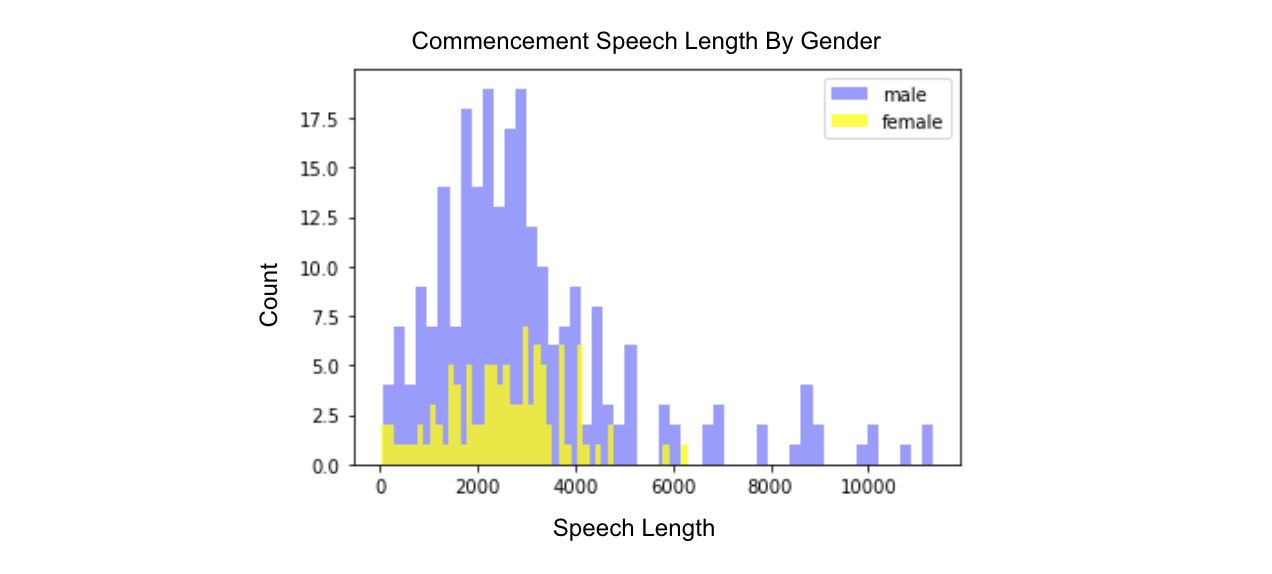

In [3]:
# image as it was saved
from IPython.display import Image
Image("Screen Shot 2020-03-08 at 11.38.48 AM.png")

## Identify Common Words Overall

### General

In [ ]:
#Create simple document-term matrix to explore common words
def simple_doc_term():
    cv = CountVectorizer(stop_words='english', ngram_range=(1,1))
    data_cv = cv.fit_transform(speeches.speech)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm.index = speeches.index
    return data_dtm

data_dtm = simple_doc_term()

In [ ]:
#top 20 most commonly said words
np.sum(data_dtm, axis=0).sort_values(ascending=False)[:20]

In [ ]:
# most of these are not meaningful and will be added to stop words list
# view the next set of 20 for more information
np.sum(data_dtm, axis=0).sort_values(ascending=False)[20:40]

### By Gender

In [ ]:
female_dtm = simple_doc_term(female)
male_dtm = simple_doc_term(males)

In [ ]:
top_female_words = np.sum(female_dtm, axis=0).sort_values(ascending=False)[:20]
top_male_words = np.sum(male_dtm, axis=0).sort_values(ascending=False)[:20]

print("Top female words:")
print(top_female_words)

print("Top male words:")
print(top_male_words)

## Parts of Speech by Gender

In [ ]:
speeches.to_csv('speeches_with_gender.csv')

In [1]:
# create a column for nouns only
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

speeches['nouns_only'] = speeches.speech.apply(nouns)

In [ ]:
# create a column for verbs only
def verbs(text):
    '''Given a string of text, tokenize the text and pull out only the verbs.'''
    is_verb = lambda pos: pos[:1] == 'V'
    tokenized = word_tokenize(text)
    all_verbs = [word for (word, pos) in pos_tag(tokenized) if is_verb(pos)] 
    return ' '.join(all_verbs)

speeches['verbs_only'] = speeches.speech.apply(verbs)

In [ ]:
# create a column for adjectives only
def adjectives(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_adj = lambda pos: pos[:3] == 'ADJ'
    tokenized = word_tokenize(text)
    all_adj = [word for (word, pos) in pos_tag(tokenized) if is_adj(pos)] 
    return ' '.join(all_adj)

speeches['adjectives_only'] = speeches.speech.apply(adjectives)

In [ ]:
def avg_number_of_words_in_column(data, column):
    doc_len_ls = []

    for speech in data[column]:
        text = speech
        text_ls = text.split(' ')
        doc_len_ls.append(len(text_ls))
    
    avg_num_words = np.mean(doc_len_ls)
    
    return avg_num_words

In [ ]:
avg_female_speech_len = np.mean(female.speech_length)
avg_male_speech_len = np.mean(males.speech_length)

In [ ]:
male_nouns = avg_number_of_words_in_column(speeches[speeches.gender=='0'], 'nouns_only')/avg_male_speech_len
female_nouns = avg_number_of_words_in_column(speeches[speeches.gender=='1'], 'nouns_only')/avg_female_speech_len

In [ ]:
male_verbs = avg_number_of_words_in_column(speeches[speeches.gender=='0'], 'verbs_only')/avg_male_speech_len
female_verbs = avg_number_of_words_in_column(speeches[speeches.gender=='1'], 'verbs_only')/avg_female_speech_len

In [ ]:
male_adj = avg_number_of_words_in_column(speeches[speeches.gender=='0'], 'adjectives_only')/avg_male_speech_len
female_adj = avg_number_of_words_in_column(speeches[speeches.gender=='1'], 'adjectives_only')/avg_female_speech_len

# Topic Modeling

## Prepare Dataframe and Helper Functions

In [ ]:
# Create a new column in the speeches dataframe with lemmatized words
lem = WordNetLemmatizer()

speeches['lemmatized_words'] = speeches.speech.apply(lambda x: x.split())
speeches.lemmatized_words = speeches.lemmatized_words.apply(lambda x: [lem.lemmatize(y) for y in x])
speeches.lemmatized_words = speeches.lemmatized_words.apply(lambda x: ' '.join(x))

In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """Displays each topic and the words that fall within them."""
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
# create stop words list
def new_stopwords():
    my_stop_words = set(['like', 'know', 'im', 'just', 'thank', 'dont', 'youre', 'get', 'would', 'said', 'thats',
                         'think', 'say', 'things', 'us', 'going', 'way', 'really', 'well', 'many', 'got', 'right', 
                         'something','thing', 'didnt', 'wa','one','went','wanted','ha','one','lot','mean', 'want', 
                         'congratulations', 'commencement','staff','speaker','trustees','board','members', 
                         'everything','guy', 'someone', 'everyone', 'ive', 'actually', 'theyre','youll', 'come', 'dr',
                         'anything', 'new', 'also', 'says', 'must', 'though','even', 'today', 'kind', 'hes', 'stuff',
                         'somebody', 'gon', 'york', 'day','women','men','woman','man','lets','id','guys', 'let','tell',
                         'cant','thought','great','look','always','cant','big','see','take','never','back','little',
                         'need','maybe','every','still','ever','two', 'around','honor', 'three','please','called',
                         'may', 'yeah','high', 'mr', 'better','part','good','first','show','feel','oh','else','whats',
                         'doesnt','sure','put','getting','later','wasnt','okay','knew', 'could', 'gonna', 'every',
                         'made', 'youve', 'much', 'theres', 'cover','none', 'acts', 'john','words','person',
                         'without', 'old', 'kid', 'order', 'everybody','ways', 'group','point', 'applause', 'adam',
                         'sarah','sara', 'bridge', 'finally', 'suppose', 'effect', 'excellent', 'probably','enough',
                         'thanks','guest','speak','turn','ago','since','havent','side','week','month', 'sense',
                         'others','days','days', 'mit', 'might', 'michael','william','david','story','place','real',
                         'word','told','away','next','came', 'find','harvard', 'number','done','night','doe','long',
                         'weve', 'talk','best','call','asked','another','keep','free','whether','end','wait','four',
                         'door','become', 'orleans', 'affect','meal', 'tap','step', 'girl','room','play', 'yes', 
                         'start', 'true','last','wood','sort', 'sometimes','tony', 'michigan','sweet','small',
                         'parent','folk','mom','dad','song','child','took', 'pas', 'across','amount',
                         'car','eye','face','bit'])

    eng_stop_words = set(stopwords.words('english'))

    new_stopwords = eng_stop_words.union(my_stop_words)
    
    return new_stopwords

## All Data Topic Modeling

Note: additional exploration was done to determine dimensionality reduction conditions. Exploration included all variations of the following. 
1. LDA, LSA, NMF 
2. CountVectorizer and TFidfVectorizer 
3. Hyperparameters including stop words, max_df, min_df, and ngram_range
4. Lemmatization and stemming
5. Part of speech: nouns only, verbs only, adjectives only, nouns + verbs, nouns + adjectives

Winning condition used below: 
* NMF with TF-IDf
* Lemmatization with all words
* Stop words above
* Max_df = .8, min_df = .3
* Single word ngrams only

In [ ]:
# use TF-IDF vectorizing
vectorizer = TfidfVectorizer(stop_words=new_stopwords, max_df=.8, min_df=.3, ngram_range=(1,1))
doc_term_object = vectorizer.fit_transform(speeches.lemmatized_words).toarray()

# create NMF object and transform the document term object created above
nmf = NMF(5, random_state=19)
doc_topic = nmf.fit_transform(doc_term_object)

#view top words in each topic
display_topics(nmf, vectorizer.get_feature_names(), 20)

Based on above, topics are determined to be:
* Career
* Education
* Hope
* Culture
* Politics

## Viewing Results

### General - All Data

In [ ]:
#create dataframe of topic distrobutions per document to add onto the speeches dataframe
topic_columns = ['career','politics','education','hope','culture']
nmf_df = pd.DataFrame(doc_topic, columns=topic_columns)

#concatenate origonal speeches dataframe and topics dataframe
categorized_speeches = pd.concat((speeches.reset_index(), nmf_df),axis=1)

# remove columns with speech info (no longer needed for analysis)
categorized_speeches = categorized_speeches.drop(['lemmatized_words', 'index'], axis=1)

# create a column to indicate the top topic for each document
categorized_speeches['top_topic'] = categorized_speeches[topic_columns].idxmax(axis=1)

# view top topics per document
categorized_speeches.top_topic.value_counts()

# save the dataframe to access later
categorized_speeches.to_csv('topic_modeling_output.csv')

In [ ]:
# plot the distrobution of top topics
x = list(categorized_speeches.top_topic.value_counts().index)
y = list(categorized_speeches.top_topic.value_counts())

chart = sns.barplot(x=x, y=y, color='#00274C')
plt.xlabel('Top Topic')
plt.ylabel('Count')
plt.title('Top Topic Distrobution')
sns.despine();

In [ ]:
# plot with t-sne

def t_sne_prep(doc_term_object)
    """Takes in a document-term matrix created during topic modeling and returns a 
    t-sne dataframe with two columns for 2-dimensional graphing and a labels column
    to indicate topic."""
    doc_term_df = pd.DataFrame(doc_term_object)

    ss = StandardScaler()
    doc_term_df = ss.fit_transform(nmf_df)

    tsne = TSNE(n_components=2, random_state=19, verbose=1, n_iter=2000, learning_rate=10)
    tsne_results = tsne.fit_transform(doc_term_df)

    #concat pca dataframe with the top topics per document
    t_sn_df = pd.concat((pd.DataFrame(tsne_results), categorized_speeches.top_topic), axis=1)
    t_sn_df = t_sn_df.rename(columns={0:'first',1:'second'})
    
    return t_sne_df

t_sne_df = t_sne_prep(doc_term_object)

# plot
fig = plt.figure(figsize=(10,8))
vis = sns.scatterplot(x=t_sn_df['first'], y=t_sn_df['second'], lw=0, s=40, hue=t_sn_df['top_topic'])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
vis.legend(loc=3)
sns.despine();

### By Gender

In [ ]:
# create separate dataframes for males and females
male_categorized_speeches = categorized_speeches[categorized_speeches.gender == '0']
female_categorized_speeches = categorized_speeches[categorized_speeches.gender == '1']

# compare percentage of each topic since the number of males > number of females
print('Top male topics:')
print(male_categorized_speeches.top_topic.value_counts(normalize=True))

print('Top female topics:')
print(female_categorized_speeches.top_topic.value_counts(normalize=True))

In [ ]:
# create a dataframe with the topic distrobutions for men and women to visualize in Tableau
topic_distro = pd.DataFrame({'men': full_m.top_topic.value_counts(normalize=True), 'women': full_f.top_topic.value_counts(normalize=True)})

# export for visualization
topic_distro.to_csv('topic_distro_gender.csv')

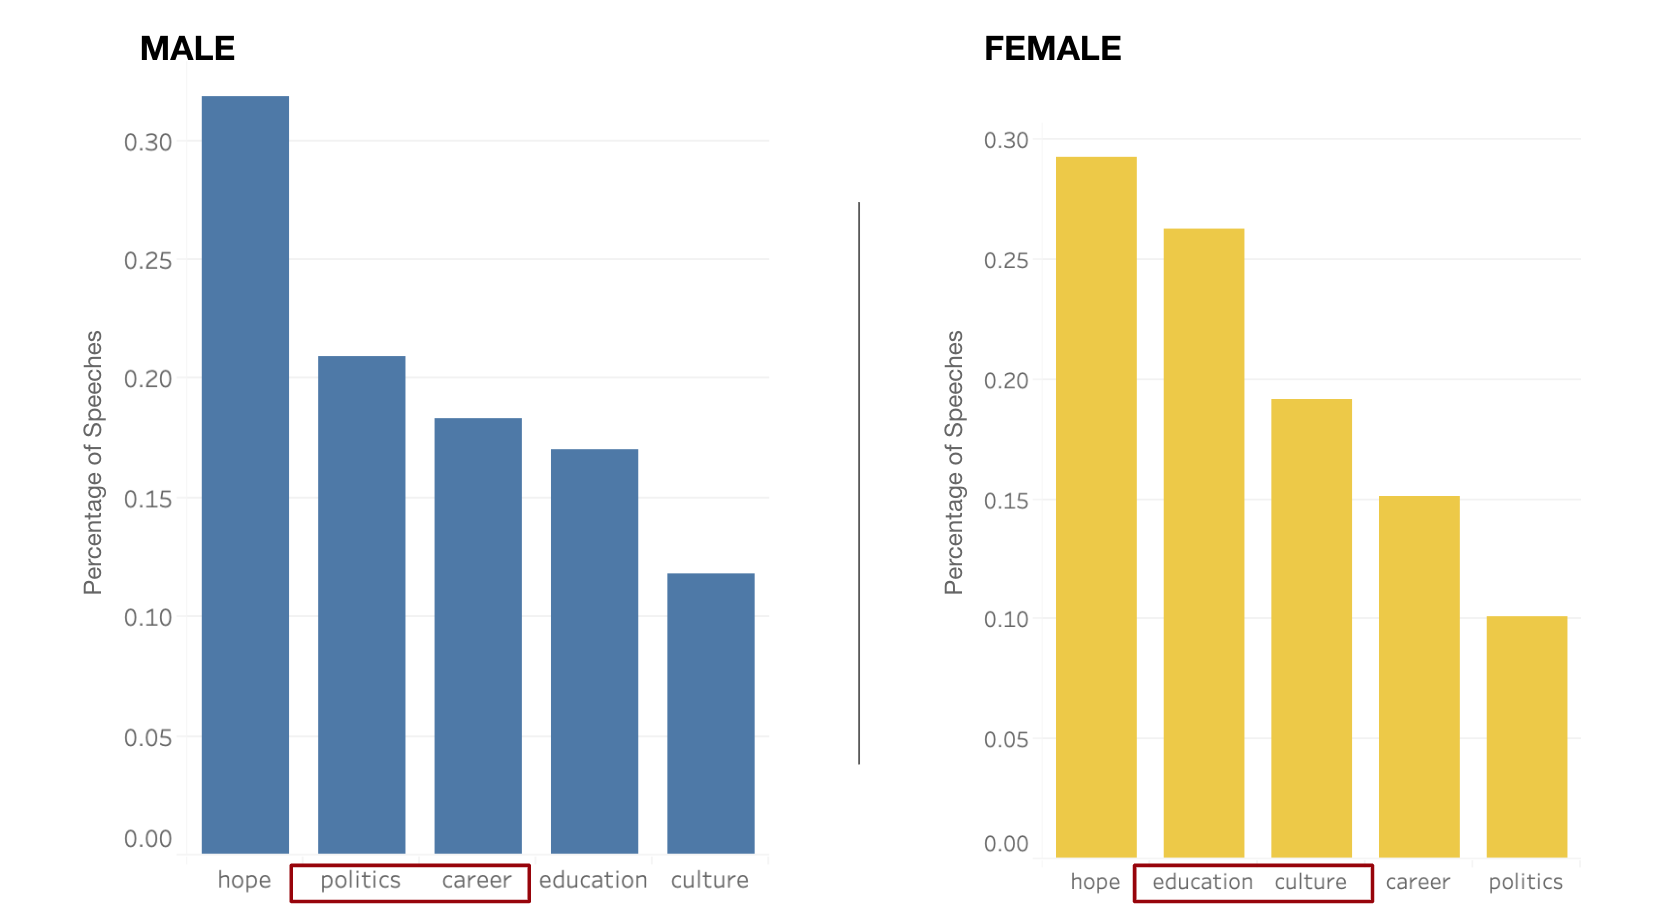

In [4]:
# Plots created in Tableau
from IPython.display import Image
Image("Screen Shot 2020-03-07 at 3.48.27 PM.png")

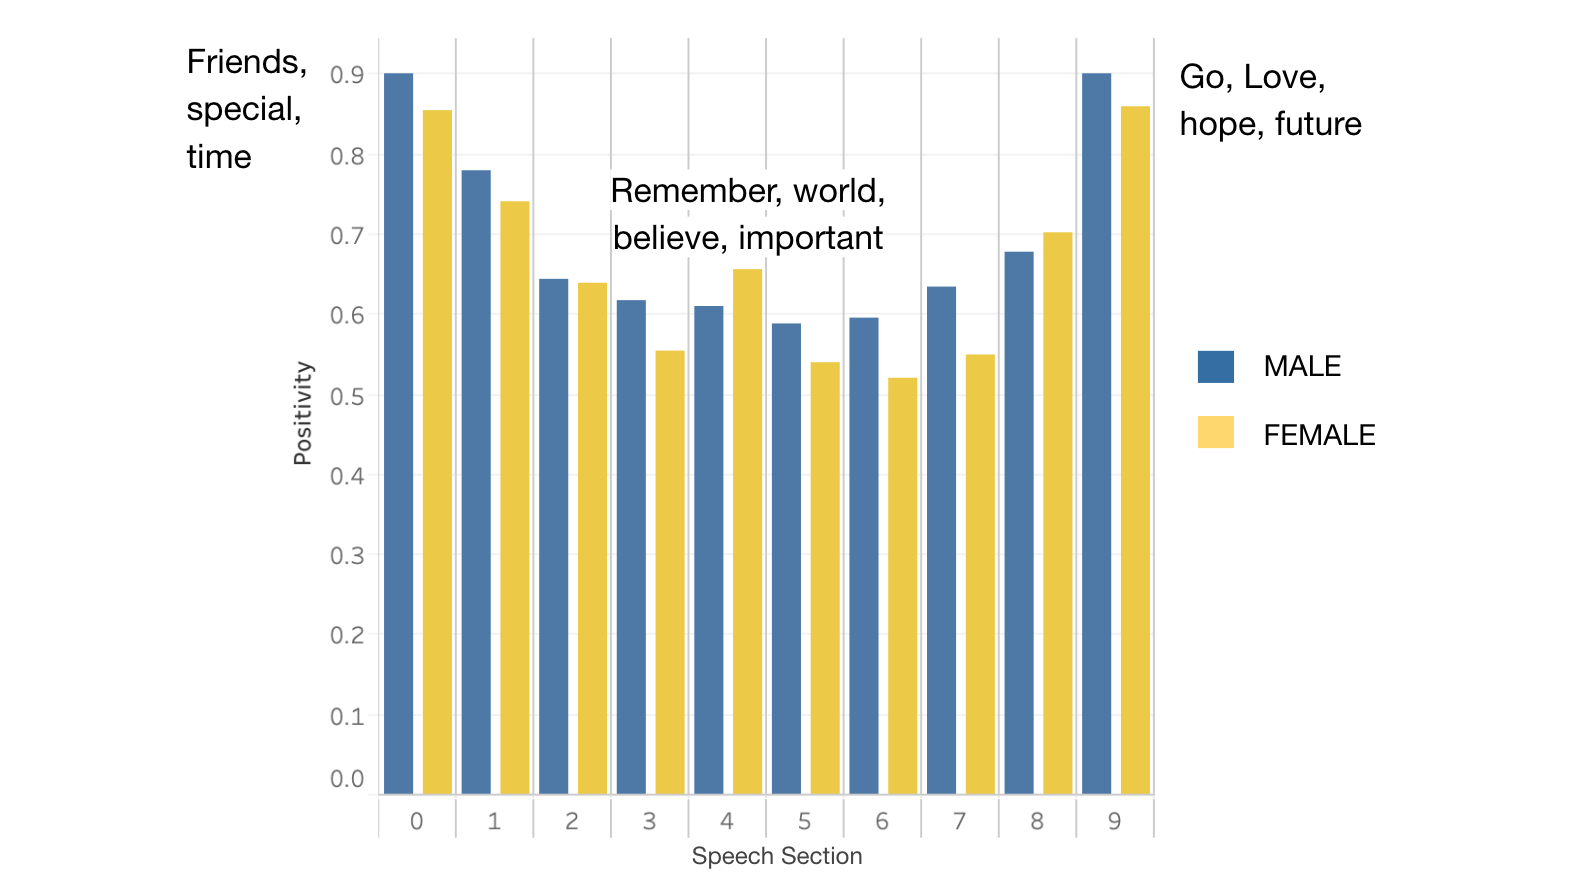

In [5]:
Image("Screen Shot 2020-03-07 at 4.24.04 PM.png")

# Sentiment Analysis

## Vader - By Gender

### Full Speeches

In [ ]:
# create a copy in case of needing to revert to previous state
sent_df = categorized_speeches.copy()

analyser = SentimentIntensityAnalyzer()

# for each of the speeches, create columns for the four sentiments captured by Vader to analyze
sent_df['pos'] = sent_df.speech.apply(lambda x: analyser.polarity_scores(x)['pos'])
sent_df['neg'] = sent_df.speech.apply(lambda x: analyser.polarity_scores(x)['neg'])
sent_df['neu'] = sent_df.speech.apply(lambda x: analyser.polarity_scores(x)['neu'])
sent_df['comp'] = sent_df.speech.apply(lambda x: analyser.polarity_scores(x)['compound'])

# view and compare results for each gender
sent_df.groupby('gender')['pos','neg','neu','compount'].agg(['mean'])

### By Sections

Observe the change in sentiment throughout the speeches to identify overarching patterns and if there are any differences between the genders. To do so, speeches are broken into 10 smaller segments and each segment has sentiment analysis applied. 

In [ ]:
# create a copy in case of needing to revert to previous state. Maintain only gender and speech 
# columns to avoid clutter
sent_df_split = categorized_speeches[['gender','speech']]

# split speeches into 10 sections, each is a new column to keep the speech together 
sent_df_split['s1'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[0:int(len(x)/10)]))
sent_df_split['s2'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[int(len(x)/10):2*int(len(x)/10)]))
sent_df_split['s3'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[2*int(len(x)/10):3*int(len(x)/10)]))
sent_df_split['s4'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[3*int(len(x)/10):4*int(len(x)/10)]))
sent_df_split['s5'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[4*int(len(x)/10):5*int(len(x)/10)]))
sent_df_split['s6'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[5*int(len(x)/10):6*int(len(x)/10)]))
sent_df_split['s7'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[6*int(len(x)/10):7*int(len(x)/10)]))
sent_df_split['s8'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[7*int(len(x)/10):8*int(len(x)/10)]))
sent_df_split['s9'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[8*int(len(x)/10):9*int(len(x)/10)]))
sent_df_split['s10'] = sent_df_split.speech.str.split().apply(lambda x: ' '.join(x[9*int(len(x)/10):10*int(len(x)/10)]))

In [ ]:
def obtain_comp_score(data, col):
    """Takes in a dataframe and column and return the compound sentiment score for the text
    in that column. Used to obtain sentiment scores for the 10 smaller sections of the 
    commencement speecches."""
    
    new_col_name = 'comp' + col
    data[new_col_name] = data[col].apply(lambda x: analyser.polarity_scores(x)['compound'])
    return data

sent_df_split = obtain_comp_score(sent_df_split, 's1')
sent_df_split = obtain_comp_score(sent_df_split, 's2')
sent_df_split = obtain_comp_score(sent_df_split, 's3')
sent_df_split = obtain_comp_score(sent_df_split, 's4')
sent_df_split = obtain_comp_score(sent_df_split, 's5')
sent_df_split = obtain_comp_score(sent_df_split, 's6')
sent_df_split = obtain_comp_score(sent_df_split, 's7')
sent_df_split = obtain_comp_score(sent_df_split, 's8')
sent_df_split = obtain_comp_score(sent_df_split, 's9')
sent_df_split = obtain_comp_score(sent_df_split, 's10')

In [ ]:
# view the average sentiment for each section of the speeches by gender
sent_by_gender = sent_df_split.groupby('gender')['comps1',
                                                'comps2',
                                                'comps3',
                                                'comps4',
                                                'comps5',
                                                'comps6',
                                                'comps7',
                                                'comps8',
                                                'comps9',
                                                'comps10'].agg(['mean'])

In [ ]:
# create a dataframe of mean sentiment by gender to export for Tableau visualization
sent_each = pd.DataFrame({'f':list(sent_by_gender.iloc[0,:].values) , 
                          'm': list(sent_by_gender.iloc[1,:].values)})

# export for vis
sent_each.to_csv('mean_sentiment_per_gender.csv')

In [ ]:
# view the overall top words per section to have an idea of where sentiment change is derived from

def top_words_by_section(data, section):
    """Takes in a dataframe and a section and returns the most commonly used words within
    that section."""
    cv = CountVectorizer(stop_words=create_stopwords(), ngram_range=(1,1))
    data_cv = cv.fit_transform(data[section])
    
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm.index = data.index
    
    top_words_ls = np.sum(data_dtm, axis=0).sort_values(ascending=False)

    return top_words_ls

# view top words in section 1
print("Top words in section 1:'\n'", top_words_by_section(sent_df_split, 's1')[:20], '\n')

# view top words in a middle section
print("Top words in section 5:'\n'", top_words_by_section(sent_df_split, 's5')[:20], '\n')

# view top words in a section 10
print("Top words in section 10:'\n'", top_words_by_section(sent_df_split, 's10')[:20])

## IBM Watson Tone Analyzer

In [ ]:
# IBM_API_KEY = os.environ['IBM_API_KEY']

from ibm_connect import ibm_connnection()

# connect to ibm with authentication key stored in separate .py file (ibm_comment)
imb_connection()

In [18]:
# re-pull dataset from MongoDB because IBM's Tone Analyzer leverages sentence structure and 
# periods were stripped away during cleaning

In [ ]:
ibm_df = pull_from_mongo()

In [ ]:
def clean_text_ibm(text):
    """Remove text in square brackets and remove words containing numbers."""

    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…:"\"><]', '', text)
    text = re.sub('\n', ' ', text)
    return text

ibm_round = lambda x: clean_text_for_ibm(x)
ibm_df.speech = speeches.speech.apply(ibm_round)

In [ ]:
# repeat other data touch ups
ibm_df = ibm_df.drop('_id', axis=1)

spanish_speeker1, spanish_speeker2 = 'Henry A. Wallace', 'Billy Collins'
ibm_df = ibm_df[ibm_df.name != spanish_speeker1]
ibm_df = ibm_df[ibm_df.name != spanish_speeker2]

ibm_df = ibm_df.drop_duplicates(keep='first')

# add gender column back in
m_f_designation = pickle.load( open( "m_f_designation.pkl", "rb" ) )
gender = re.sub('\n', ' ', m_f_designation).split(' ')
ibm_df["gender"] = gender

In [20]:
# due to YouTube transcripts, many of the speeches do not include periods. To isolate those
# that do, create a column that indicates the number of sentences per speech.
ibm_df['sent_len'] = ibm_df.speech.apply(lambda x: len(sent_tokenize(x)))

# select only those with a reasonable amount of sentences
ibm_df_use = ibm_df[ibm_df.sent_len >= 50]

In [ ]:
# create separate dataframes for male and female to run through Watson as gender information
# will otherwise be lost
f_for_ibm = ibm_df_use[ibm_df_use.gender =='1']
m_for_ibm = ibm_df_use[ibm_df_use.gender =='0']

# run watson for female speeches and store in result list
resp_f_ls = []

for s in f_for_ibm.speech:
    resp = tone_analyzer.tone(
        {'text': s},
        content_type='application/json',
        sentences=False
    )
    
    resp_f_ls.append(resp.result)

# run watson for male speeches and store in result list
resp_m_ls = []

for s in m_for_ibm.speech:
    resp = tone_analyzer.tone(
        {'text': s},
        content_type='application/json',
        sentences=False
    )
    
    resp_m_ls.append(resp.result)

In [ ]:
# Watson output is a dictionary of dictionaries. Access information on tone and store 
# as a new dataframe for easier accessing

# create female df & and add gender indicator column
start_f_df = pd.DataFrame.from_dict(resp_f_ls[0]['document_tone']['tones'])
for i in range(1, len(resp_f_ls)):
    start_f_df = pd.concat((start_f_df, pd.DataFrame.from_dict(resp_f_ls[i]['document_tone']['tones'])), axis=0)

start_f_df['gender'] = '1'

# create male df and add gender indicator column
start_m_df = pd.DataFrame.from_dict(resp_m_ls[0]['document_tone']['tones'])
for i in range(len(resp_m_ls)):
    start_m_df = pd.concat((start_m_df, pd.DataFrame.from_dict(resp_m_ls[i]['document_tone']['tones'])), axis=0)

start_m_df['gender'] = '0'

In [ ]:
# concatenate the male and female dataframes and export to csv for Tableau visualization
full_sent_df = pd.concat((start_f_df, start_m_df), axis=0)

full_sent_df.to_csv('full_sent_df.csv')